## C-M(-C) 2010 H-D testing ##

In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
import csv

# import our own small lib. I access this one through PyCharm
import nsidc

In [11]:
#2. OPEN THE AVAILABLE DATASETS FOR 2010

# 25 km data
# ds_37ghz_25km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_25km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc')
# ds_37ghz_25km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-A_2010.nc')
# ds_37ghz_25km_V_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-D_2010.nc')
# ds_89ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89H-A_2010.nc')
# ds_89ghz_3km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_V_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89V-A_2010.nc')

# 3.125 km data
ds_37ghz_3km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-36H-A_2010.nc')

ds = ds_37ghz_25km_H_D

# CHIRPS rainfall data 
path = ("C:\\Users\\908138\\githubdata\\chirps\\box_bonou\\box_bonou_mean_2010.csv")
# ds_p = pd.read_csv(path)
# ds_p.to_xarray()
ds_p = pd.read_csv(path, index_col='date',names=['date','precipitation'], skiprows=1)
precipitation = ds_p['precipitation']
# ds_p

# TEMPERATURE DATA
path_temp = ("C:\\Users\\908138\\githubdata\\temperature\\bohicon\\t_bohicon_daily_2010.csv")
ds_temp = pd.read_table(path_temp,sep=';')
temperature = ds_temp['TAVG']

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


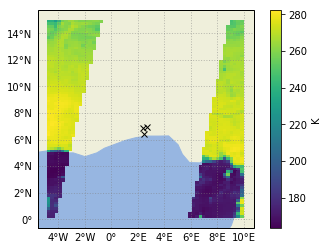

In [12]:
#3. POINTS OF INTEREST

# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
# ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# Ouémé delta 3 point calibration method - this is the current method that I'm testing.
points_interest = [(2.4526, 6.4365),  #original (2.43, 6.43) #wet calibration - always covered in water (lake Nokoué)             
                   (2.69936, 6.90851), #(2.6386, 6.8748),# (2.5063, 6.9093), #original (2.69936, 6.90851), #bonou dry calibration
                   (2.4334, 6.8748) #original(2.44936, 6.90851) #bonou measurement cell
                  ]

# (2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
# points_interest = [(2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
                   
#                    (2.25, 6.57),  #dry calibration 1 - never affected by "fluvial" inundations
#                    (2.43, 6.55),  #measurement cell 1 - sometimes affected, real point of interest
                   
#                    (2.25, 6.82),  #dry calibration 2
#                    (2.43, 6.80),  #measurement cell 2
                   
#                    (2.25, 7.40),  #dry calibration 3 (7.07 normally)
#                    (2.43, 7.05),  #measurement cell 3
                   
#                    (2.25, 7.40),  #dry calibration 4 (7.32 normally)
#                    (2.43, 7.30),   #measurement cell 4
                   
#                    (2.69936, 6.90851), #bonou dry calibration
#                    (2.44936, 6.90851) #bonou measurement cell
#                   ]


# # Ouémé gaging station Hounkpe and Badou (2007)
# points_interest = [(2.4406387000000223, 6.893251099999999),
#                    (2.2999999999999545, 7.099999999999999),
#                    (2.4851462999999967, 8.0335995),
#                    (2.0499999999999545, 7.566667)
# ]

#Some coding to visualise the area. 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

In [13]:
#4. COORDINATE SYSTEM PROJECTIONS
#Transforming the coordinate system. The data is available from a Measures dataset by NASA with a weird projection system
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


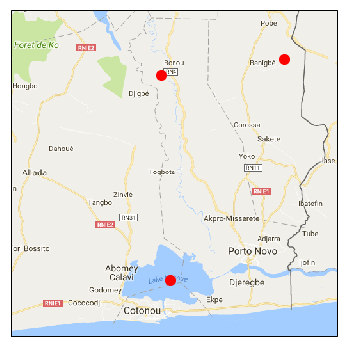

In [14]:
# 5.VISUALISE POINTS OF INTEREST
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(6, 6))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())

plt.show()

# Loading Brightness Temperature Data 2010

In [19]:
#6. LOAD AND MODIFY TB (BRIGHTNESS TEMPERATURE) TIMESERIES

points_x, points_y = zip(*points_xy)

# Loading the data in x-y coordinates
# ts_37ghz_3km_H_A = ds_37ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_3km_H_D = ds_37ghz_3km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_H_A = ds_37ghz_25km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_D = ds_37ghz_25km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_A = ds_37ghz_25km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_D = ds_37ghz_25km_V_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_89ghz_3km_H_A = ds_89ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

# ts_89ghz_3km_V_A = ds_89ghz_3km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

# Fill up the NaN entries in the raw data series with values to obtain daily consistency (and optionally plot):

#----------values_37ghz_25km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_H_D = ts_37ghz_25km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_H_D_wet= pd.DataFrame(values_37ghz_25km_H_D[0])
TB_37ghz_25km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma = TB_37ghz_25km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_H_D_dry= pd.DataFrame(values_37ghz_25km_H_D[1])
TB_37ghz_25km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma = TB_37ghz_25km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement= pd.DataFrame(values_37ghz_25km_H_D[2])
TB_37ghz_25km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma = TB_37ghz_25km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_37ghz_3km_H_D----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_3km_H_D = ts_37ghz_3km_H_D['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_3km_H_D_wet= pd.DataFrame(values_37ghz_3km_H_D[0])
TB_37ghz_3km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma = TB_37ghz_3km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_3km_H_D_dry= pd.DataFrame(values_37ghz_3km_H_D[1])
TB_37ghz_3km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma = TB_37ghz_3km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement= pd.DataFrame(values_37ghz_3km_H_D[2])
TB_37ghz_3km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma = TB_37ghz_3km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


# #----------values_37ghz_3km_H_A----------------------------------------------------------------------------------
# # plt.figure(figsize=(14,6))
# values_37ghz_3km_H_A = ts_37ghz_3km_H_A['TB'].values
# # for n in range(len(ts_37ghz_25km_H_A['TB'])):
# #     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
# TB_37ghz_3km_H_A_wet= pd.DataFrame(values_37ghz_3km_H_A[0])
# TB_37ghz_3km_H_A_wet.fillna(method='bfill',inplace=True)
# TB_37ghz_3km_H_A_wet_ma = TB_37ghz_3km_H_A_wet.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_wet

# TB_37ghz_3km_H_A_dry= pd.DataFrame(values_37ghz_3km_H_A[1])
# TB_37ghz_3km_H_A_dry.fillna(method='bfill',inplace=True)
# TB_37ghz_3km_H_A_dry_ma = TB_37ghz_3km_H_A_dry.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_dry

# TB_37ghz_3km_H_A_measurement= pd.DataFrame(values_37ghz_3km_H_A[2])
# TB_37ghz_3km_H_A_measurement.fillna(method='bfill',inplace=True)
# TB_37ghz_3km_H_A_measurement_ma = TB_37ghz_3km_H_A_measurement.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_measurement


# #----------values_37ghz_25km_H_A----------------------------------------------------------------------------------
# # plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# # for n in range(len(ts_37ghz_25km_H_A['TB'])):
# #     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
# TB_37ghz_25km_H_A_wet= pd.DataFrame(values_37ghz_25km_H_A[0])
# TB_37ghz_25km_H_A_wet.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_H_A_wet_ma = TB_37ghz_25km_H_A_wet.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_wet

# TB_37ghz_25km_H_A_dry= pd.DataFrame(values_37ghz_25km_H_A[1])
# TB_37ghz_25km_H_A_dry.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_H_A_dry_ma = TB_37ghz_25km_H_A_dry.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_dry

# TB_37ghz_25km_H_A_measurement= pd.DataFrame(values_37ghz_25km_H_A[2])
# TB_37ghz_25km_H_A_measurement.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_H_A_measurement_ma = TB_37ghz_25km_H_A_measurement.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_measurement

# #----------values_37ghz_25km_V_A----------------------------------------------------------------------------------
# # plt.figure(figsize=(14,6))
# values_37ghz_25km_V_A = ts_37ghz_25km_V_A['TB'].values
# # for n in range(len(ts_37ghz_25km_H_A['TB'])):
# #     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
# TB_37ghz_25km_V_A_wet= pd.DataFrame(values_37ghz_25km_V_A[0])
# TB_37ghz_25km_V_A_wet.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_A_wet_ma = TB_37ghz_25km_V_A_wet.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_wet

# TB_37ghz_25km_V_A_dry= pd.DataFrame(values_37ghz_25km_V_A[1])
# TB_37ghz_25km_V_A_dry.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_A_dry_ma = TB_37ghz_25km_V_A_dry.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_dry

# TB_37ghz_25km_V_A_measurement= pd.DataFrame(values_37ghz_25km_V_A[2])
# TB_37ghz_25km_V_A_measurement.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_A_measurement_ma = TB_37ghz_25km_V_A_measurement.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_measurement


# #----------values_37ghz_25km_V_D----------------------------------------------------------------------------------
# # for n in range(len(ts_37ghz_25km_H_A['TB'])):
# values_37ghz_25km_V_D = ts_37ghz_25km_V_D['TB'].values
# #     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

# TB_37ghz_25km_V_D_wet= pd.DataFrame(values_37ghz_25km_V_D[0])
# TB_37ghz_25km_V_D_wet.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_D_wet_ma = TB_37ghz_25km_V_D_wet.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_D_wet

# TB_37ghz_25km_V_D_dry= pd.DataFrame(values_37ghz_25km_V_D[1])
# TB_37ghz_25km_V_D_dry.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_D_dry_ma = TB_37ghz_25km_V_D_dry.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_D_dry

# TB_37ghz_25km_V_D_measurement= pd.DataFrame(values_37ghz_25km_V_D[2])
# TB_37ghz_25km_V_D_measurement.fillna(method='bfill',inplace=True)
# TB_37ghz_25km_V_D_measurement_ma = TB_37ghz_25km_V_D_measurement.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_D_measurement

# #----------values_89ghz_3km_H_A----------------------------------------------------------------------------------
# # plt.figure(figsize=(14,6))
# values_89ghz_3km_H_A = ts_89ghz_3km_H_A['TB'].values
# # for n in range(len(ts_37ghz_25km_H_A['TB'])):
# #     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
# TB_89ghz_3km_H_A_wet= pd.DataFrame(values_89ghz_3km_H_A[0])
# TB_89ghz_3km_H_A_wet.fillna(method='bfill',inplace=True)
# TB_89ghz_3km_H_A_wet_ma = TB_89ghz_3km_H_A_wet.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_wet

# TB_89ghz_3km_H_A_dry= pd.DataFrame(values_89ghz_3km_H_A[1])
# TB_89ghz_3km_H_A_dry.fillna(method='bfill',inplace=True)
# TB_89ghz_3km_H_A_dry_ma = TB_89ghz_3km_H_A_dry.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_dry

# TB_89ghz_3km_H_A_measurement= pd.DataFrame(values_89ghz_3km_H_A[2])
# TB_89ghz_3km_H_A_measurement.fillna(method='bfill',inplace=True)
# TB_89ghz_3km_H_A_measurement_ma = TB_89ghz_3km_H_A_measurement.rolling(window=4,center=False).mean()
# # TB_37ghz_25km_H_A_measurement

print('done')

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  import sys
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  if __name__ == '__main__':


done


# WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


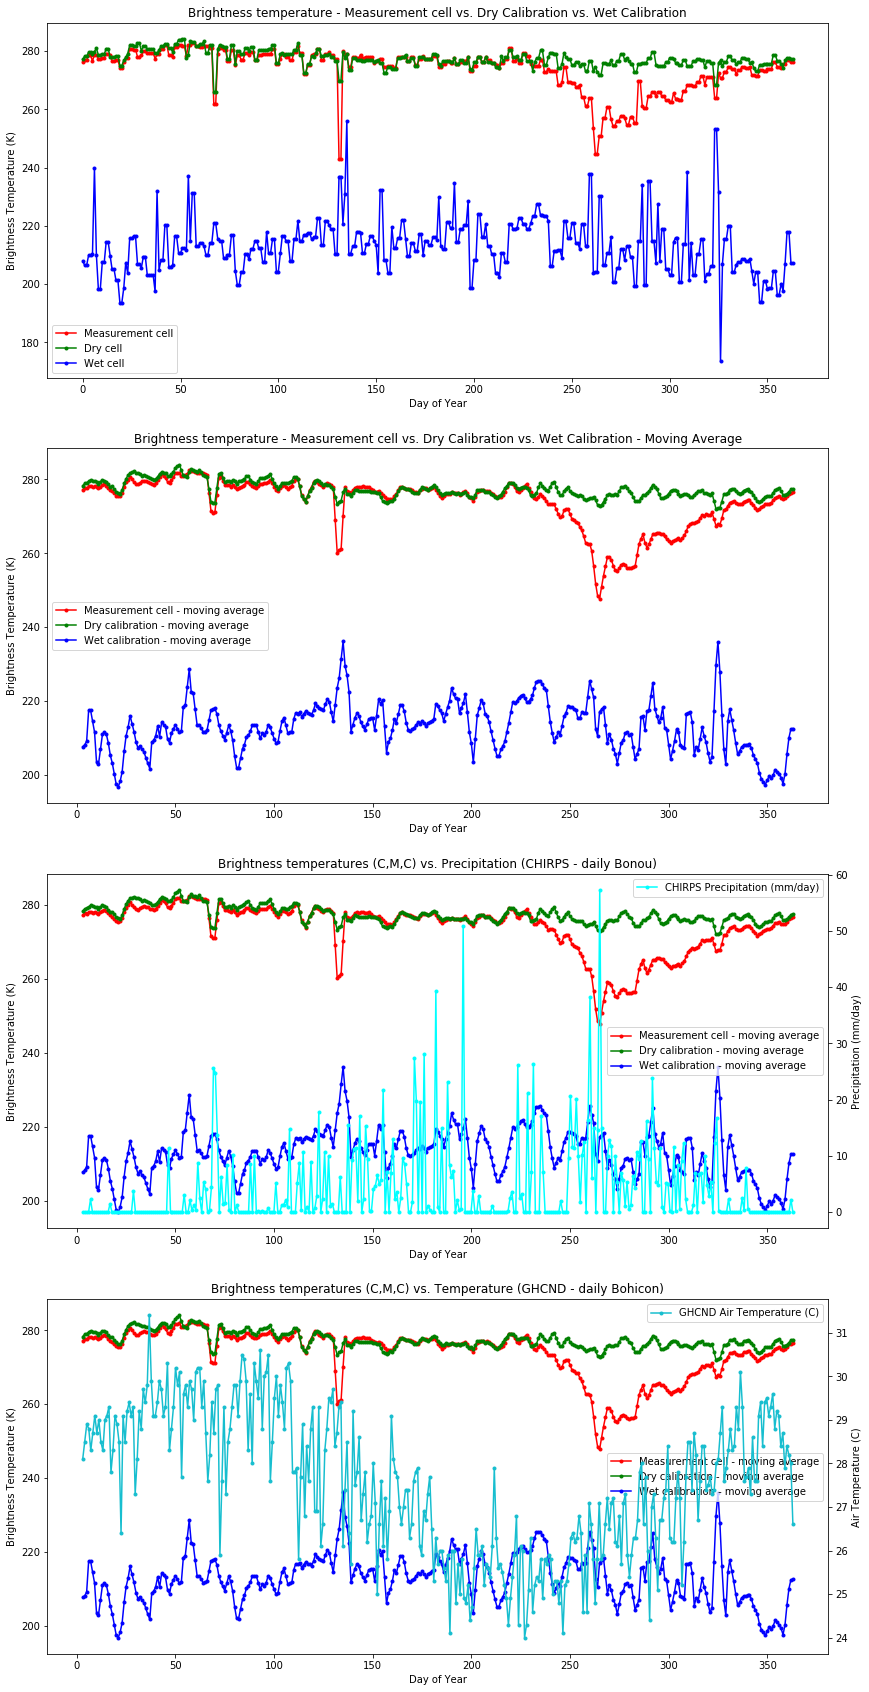

In [20]:
# PLOT WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

#----------ORIGINAL----------------------------------------------------------------------------------------
fig = plt.figure(figsize=(14,30))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
ax1 = fig.add_subplot(411) 
plt.title('Brightness temperature - Measurement cell, Dry Calibration, Wet Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='red', label = 'Measurement cell')
ax1.plot(TB_37ghz_25km_H_D_dry, marker='.', color='green', label = 'Dry cell')
ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Wet cell')
# 3 km data
# ax1.plot(TB_37ghz_3km_H_D_measurement, marker='.', color='C4', label = 'Measurement cell 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry, marker='.', color='C5', label = 'Dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_wet, marker='.', color='C6', label = 'Wet cell - 3 km')
plt.legend(loc='best')
 
    
#----------MOVING AVERAGE----------------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
ax2 = fig.add_subplot(412)
# 25 km data
ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry cell - moving average')
ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet cell - moving average')
# 3 km data
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.legend()
plt.title('Brightness temperature - Measurement cell, Dry Calibration, Wet Calibration - Moving Average')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

#----------MOVING AVERAGE + PRECIPITATION----------------------------------------------------------------------------------------
ax3 = fig.add_subplot(413)
# 25 km data
ax3.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
ax3.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry cell - moving average')
ax3.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet cell - moving average')
# 3 km data
# ax3.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
# ax3.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
# ax3.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.title('Brightness temperature (C,M,C) vs. Precipitation (CHIRPS - daily Bonou)')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

ax4 = fig.add_subplot(413)
plt.legend(loc=5)

ax4 = fig.add_subplot(413, frameon = False)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.xaxis.set_visible(False)
# ax4 = plt.axes()
# x_axis = ax4.axes.get_xaxis()
# x_axis.set_visible(False)
precipitation = ax4.plot(ds_p, marker='.', color = 'cyan', label = 'CHIRPS Precipitation (mm/day)')
plt.ylabel('Precipitation (mm/day)')
plt.legend(loc='best')

# ds_precipitation = ax3.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')

#----------MOVING AVERAGE + TEMPERATURE----------------------------------------------------------------------------------------
ax5 = fig.add_subplot(414)
# 25 km data
ax5.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
ax5.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry cell - moving average')
ax5.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet cell - moving average')
# 3 km data
# ax5.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
# ax5.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
# ax5.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.title('Brightness temperature (C,M,C) vs. Temperature (GHCND - daily Bohicon)')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

# ax6 = fig.add_subplot(314)
plt.legend(loc=5)

ax6 = fig.add_subplot(414, frameon = False)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.xaxis.set_visible(False)
# ax4 = plt.axes()
# x_axis = ax4.axes.get_xaxis()
# x_axis.set_visible(False)
ax6.plot(temperature, marker='.', color = 'C9', label = 'GHCND Air Temperature (C)')
plt.ylabel('Air Temperature (C)')
plt.legend(loc='best')

#--------TESTING---------------------------------------------------------------------------------------



# Load Discharge Data - Bonou 2010

In [21]:
# Discharge data
path = (r"C:\\Users\\908138\\githubdata\\discharge\\bonou.csv")
df = pd.read_csv(path,skiprows=0,delimiter=';')
df.columns = ['doy','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

q_2010 = df[['2010']]
doy = df[['doy']]

# C-M Ratio

,0
0,NaN
1,NaN
2,NaN


The RMSE between CMC_be and CM_be is: 0.9578838435867056 ??
The NRMSE between CMC_be and CM_be is: 1.9855684432774319 ??
Variance CMC is: 0.008512332755058874
Variance of CM is: 0.00048563488354251214
Covariance of CMC-CM is: nan
The Pearson correlation coefficient of CMC-CM is: nan
First day that Q > 800 m3/s: 239
The CMC ratio when Q > 800 is: 0.06415764265237361
Last day that Q > 800 m3/s: 304
The CMC ratio when Q > 800 is: 0.06415764265237361
The total days of Q > 800 is: 65
Qmax is 1060.0 and occurs on day: 263
CMC max is 0.4504734806201529 and occurs on day: 265


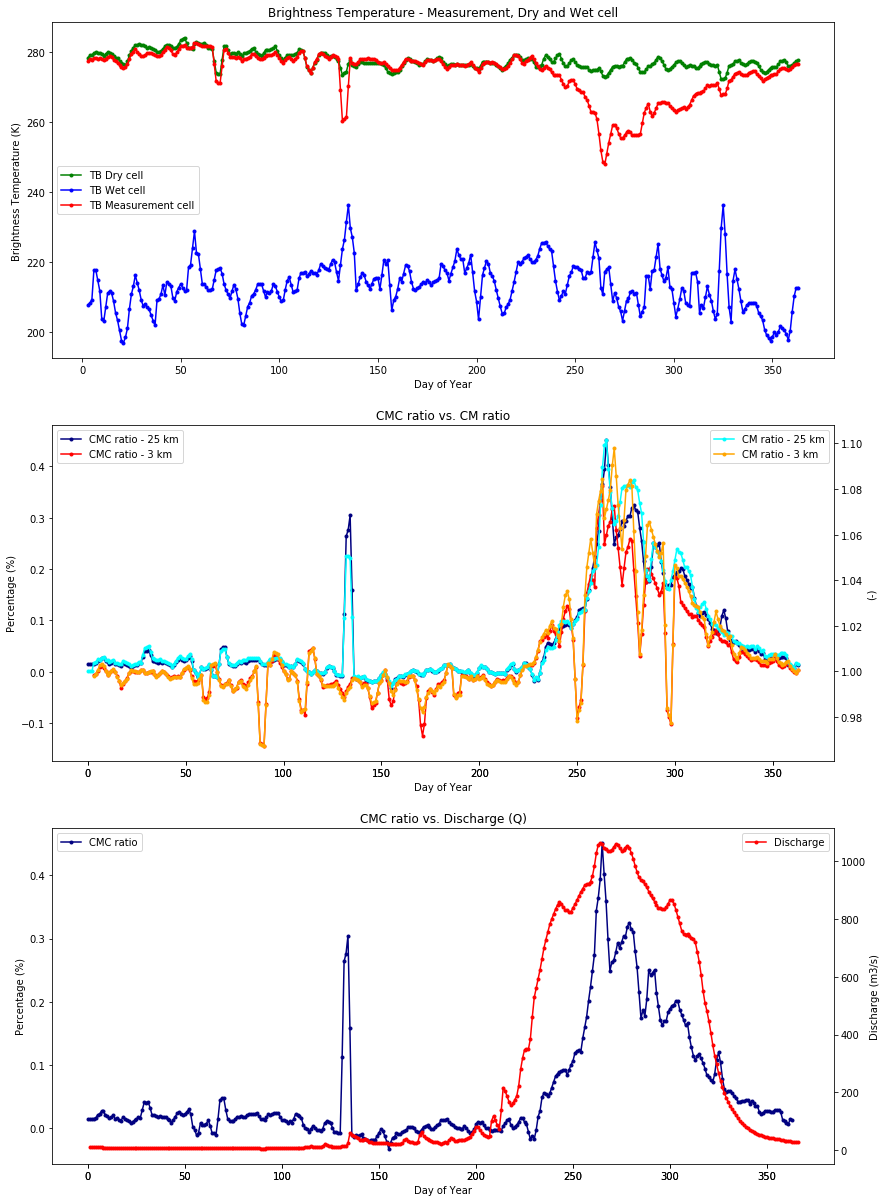

In [37]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define cells - BEST ESTIMATE
C_dry_be = TB_37ghz_25km_H_D_dry_ma #be = best estimate, to distinguish the cells from other (reference) CM(C) ratios
C_wet_be = TB_37ghz_25km_H_D_wet_ma
M_be = TB_37ghz_25km_H_D_measurement_ma
# Add cells to test
C_dry_test1 = TB_37ghz_3km_H_D_dry_ma #testing, especially with combinations of tile sizes for the stability of the signal
C_wet_test1 = TB_37ghz_3km_H_D_wet_ma
M_test1 = TB_37ghz_3km_H_D_measurement_ma

#CM(C) Ratio - BEST ESTIMATE
CM_be = (C_dry_be / M_be)
CM_be[0:3] = 1
# CM_be[CM_be<0] = CM_be.fillna(method='ffill',inplace=True) #Discard values < 0
CMC_be = (C_dry_be - M_be)/(C_dry_be - C_wet_be)
CMC_be[0:3] = 0.015
# CMC_be[CMC_be<0] = CMC_be.fillna(method='ffill',inplace=True) #Discard values < 0
# CM(C) Ratio Test
CM_test1 = (C_dry_test1 / M_test1)
# CM_test1[CM_test1<0] = CM_test1.fillna(method='ffill',inplace=True) # Discard values < 0
CMC_test1 = (C_dry_test1 - M_test1)/(C_dry_test1 - C_wet_test1)
# CMC_test1[CMC_test1<0] = CMC_test1.fillna(method='ffill',inplace=True) # Discard values < 0


# #SOMETHING WRONG WITH THE CM RATIO'S
# #Define cells - BEST ESTIMATE
# C_dry_be = TB_37ghz_25km_H_D_dry_ma #be = best estimate, to distinguish the cells from other (reference) CM(C) ratios
# C_wet_be = TB_37ghz_25km_H_D_wet_ma
# M_be = TB_37ghz_25km_H_D_measurement_ma
# # # Add cells to test
# C_dry_test1 = TB_37ghz_3km_H_D_dry_ma #testing, especially with combinations of tile sizes for the stability of the signal
# C_wet_test1 = TB_37ghz_3km_H_D_wet_ma
# M_test1 = TB_37ghz_3km_H_D_measurement_ma

# #CM(C) Ratio - BEST ESTIMATE
# # CM_nan = (C_dry_be / M_be)
# # CM_be = CM_nan.fillna(1)
# CM_be = (C_dry_be / M_be)
# CM = CM_be

# # CM_be[CM_be<0] = CM_be.fillna(method='ffill',inplace=True) #Discard values < 0
# CMC_be = (C_dry_be - M_be)/(C_dry_be - C_wet_be)
# # CMC_nan = (C_dry_be - M_be)/(C_dry_be - C_wet_be)
# # CMC_be = CMC_nan.fillna(0.015)
# CMC = CMC_be
# # CMC_be[CMC_be<0] = CMC_be.fillna(method='ffill',inplace=True) #Discard values < 0
# # CM(C) Ratio Test
# CM_test1 = (C_dry_test1 / M_test1)
# # CM_test1[CM_test1<0] = CM_test1.fillna(method='ffill',inplace=True) # Discard values < 0
# CMC_test1 = (C_dry_test1 - M_test1)/(C_dry_test1 - C_wet_test1)
# # CMC_test1[CMC_test1<0] = CMC_test1.fillna(method='ffill',inplace=True) # Discard values < 0

fig = plt.figure(figsize=(14,21))

#---------Plot the individual TB's-------------------------------------
ax1 = fig.add_subplot(311)
# Best estimate data
ax1.plot(C_dry_be, marker='.', color='g', label = 'TB Dry cell')
ax1.plot(C_wet_be, marker='.', color='b', label = 'TB Wet cell')
ax1.plot(M_be, marker='.', color='r', label = 'TB Measurement cell')
# # Test data
# ax1.plot(C_dry_test1, marker='.', color='C4', label = 'TB Dry cell - 3 km test')
# ax1.plot(C_wet_test1, marker='.', color='C5', label = 'TB Wet cell - 3 km test')
# ax1.plot(M_test1, marker='.', color='C6', label = 'TB Measurement cell - 3 km test')

ax1.legend()


plt.title('Brightness Temperature - Measurement, Dry and Wet cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

#-------Plot the CM Ratio vs. CMC Ratio----------------------------------
ax2 = fig.add_subplot(312)
plt.title('CMC ratio vs. CM ratio')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax2.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio - 25 km')
ax2.plot(CMC_test1,marker='.', color='red', label = 'CMC ratio - 3 km')
ax2.legend(loc=2)

ax3 = fig.add_subplot(312, frameon = False)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.ylabel('(-)')
ax3.plot(CM_be,marker='.', color='cyan', label = 'CM ratio - 25 km')
ax3.plot(CM_test1,marker='.', color='orange', label = 'CM ratio - 3 km')
ax3.legend()

# navy_patch = mpatches.Patch(color='navy', label='CM ratio')
# goldenrod_patch = mpatches.Patch(color='goldenrod', label='CMC ratio')
# plt.legend(handles=[navy_patch,goldenrod_patch])

# red_patch = mpatches.Patch(color='red', label='Discharge (m3/s)')
# blue_patch = mpatches.Patch(color='blue', label='C/M/C ratio (%)')
# # green_patch = mpatches.Patch(color='green', label='C/M ratio (-)')
# plt.legend(handles=[red_patch,blue_patch])
# plt.show()


#---------Plot Q vs. CMC Ratio------------------------------------
ax4 = fig.add_subplot(313)
plt.title('CMC ratio vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax4.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio')
# ax4.plot(CMC_test1,marker='.', color='C7', label = 'CMC ratio - 3 km test')
ax4.legend(loc=2)

ax5 = fig.add_subplot(313, sharex=ax4, frameon=False)
q_dis = ax5.plot(doy,q_2010, linestyle='-', color='red',marker='.', label = 'Discharge')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax5.legend()

#--------Testing CMC-CM------------------------------
def rmse(CMC, CM):
    return np.sqrt(((CMC - CM) ** 2).mean())
rmse = rmse(CMC[0],CM[0])
print('The RMSE between CMC_be and CM_be is:',rmse,'??')

def nrmse(CMC, CM):
    return np.sqrt(((CMC - CM) ** 2).mean())/(CMC.max() - CMC.min())
nrmse = nrmse(CMC[0],CM[0])
print('The NRMSE between CMC_be and CM_be is:',nrmse,'??')

var_cmc = CMC[0].var()
print('Variance CMC is:',var_cmc)

var_cm = CM[0].var()
print('Variance of CM is:', var_cm)

cov_cmc_cm = np.cov(CMC[0],CM[0])
print('Covariance of CMC-CM is:',cov_cmc_cm.item(2))

corr_cmc_cm = np.corrcoef(CMC[0],CM[0])
print('The Pearson correlation coefficient of CMC-CM is:',corr_cmc_cm.item(2))

#----------Testing CMC vs. Q--------------------------------------

thr_sap_800 = q_2010 >= 800
thr_sap_700 = q_2010 >= 700
thr_sap_500 = q_2010 >= 500

t_500_start = np.where(q_2010 > 500)[0][0]
t_700_start = np.where(q_2010 > 700)[0][0]
t_800_start = np.where(q_2010 > 800)[0][0]
print('First day that Q > 800 m3/s:',t_800_start)

cmc_500_start = CMC[0][t_500_start]
cmc_700_start = CMC[0][t_700_start]
cmc_800_start = CMC[0][t_800_start]
print('The CMC ratio when Q > 800 is:',cmc_800_start)

t_500_end_reverse = np.where(q_2010[::-1] > 500)[0][0]
t_500_end = len(q_2010)-t_500_end_reverse
t_700_end_reverse = np.where(q_2010[::-1] > 700)[0][0]
t_700_end = len(q_2010)-t_700_end_reverse
t_800_end_reverse = np.where(q_2010[::-1] > 800)[0][0]
t_800_end = len(q_2010)-t_800_end_reverse
print('Last day that Q > 800 m3/s:',t_800_end)

cmc_500_ss = CMC[0][t_500_end]
cmc_700_ss = CMC[0][t_700_end]
cmc_800_ss = CMC[0][t_800_end]
print('The CMC ratio when Q > 800 is:',cmc_800_start)

t_500_total = (q_2010 > 500).sum()
t_700_total = (q_2010 > 700).sum()
t_800_total = (q_2010 > 800).sum()
print('The total days of Q > 800 is:',t_800_total[0])

q_2010_max = q_2010.max()[0]
t_qmax = np.where(q_2010 == q_2010_max)[0][0]
print('Qmax is',q_2010_max,'and occurs on day:',t_qmax)

cmc_max = CMC.max()[0]
t_cmc_max = np.where(CMC == cmc_max)[0][0]
print('CMC max is',cmc_max,'and occurs on day:',t_cmc_max)

